In [2]:
import random
import numpy as np
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
from shapely.geometry import LineString


In [3]:
north, south, east, west = 31.5825, 31.4667, 74.4298, 74.2306 
# Retrieve road network within the bounding box
G = ox.graph_from_bbox(north, south, east, west, network_type='drive')
node_coordinates = np.array([[data['y'], data['x']] for _, data in G.nodes(data=True)])
GRIDSIZE = (40, 40)  
start = (31.5825, 74.4298)  # ambulance station
destination = (31.4667, 74.2306)  # accident site
obstacles = [(31.54, 74.25), (31.52, 74.27), (31.48, 74.29)]  

def graph_to_grid(G, GRIDSIZE, obstacles):
    north, east = np.max(node_coordinates, axis=0)
    south, west = np.min(node_coordinates, axis=0)
    GRIDSIZE = (GRIDSIZE[0] + 1, GRIDSIZE[1] + 1)
    grid = np.zeros(GRIDSIZE)
    nodes = {node: (int((north - data['y']) * GRIDSIZE[0] / (north - south)),
                    int((data['x'] - west) * GRIDSIZE[1] / (east - west)))
             for node, data in G.nodes(data=True)}
    for u, v, data in G.edges(keys=False, data=True):
        if 'geometry' in data:
            line = LineString(data['geometry'])
            coords = np.array(line.coords)
            for point in coords:
                x, y = int((north - point[1]) * GRIDSIZE[0] / (north - south)), \
                       int((point[0] - west) * GRIDSIZE[1] / (east - west))
                if 0 <= x < GRIDSIZE[0] and 0 <= y < GRIDSIZE[1]:
                    grid[x, y] = 1
        else:
            x1, y1 = nodes[u]
            x2, y2 = nodes[v]
            dx = abs(x2 - x1)
            dy = abs(y2 - y1)
            x, y = x1, y1
            sx = 1 if x1 < x2 else -1
            sy = 1 if y1 < y2 else -1
            if dx > dy:
                err = dx / 2.0
                while x != x2:
                    if 0 <= x < GRIDSIZE[0] and 0 <= y < GRIDSIZE[1]:
                        grid[x, y] = 1
                    err -= dy
                    if err < 0:
                        y += sy
                        err += dx
                    x += sx
            else:
                err = dy / 2.0
                while y != y2:
                    if 0 <= x < GRIDSIZE[0] and 0 <= y < GRIDSIZE[1]:
                        grid[x, y] = 1
                    err -= dx
                    if err < 0:
                        x += sx
                        err += dy
                    y += sy
            if 0 <= x < GRIDSIZE[0] and 0 <= y < GRIDSIZE[1]:
                grid[x, y] = 1
    
    for obstacle in obstacles:
        x = int((north - obstacle[0]) * GRIDSIZE[0] / (north - south))
        y = int((obstacle[1] - west) * GRIDSIZE[1] / (east - west))
        if 0 <= x < GRIDSIZE[0] and 0 <= y < GRIDSIZE[1]:
            grid[x, y] = -1
    
    return grid

# Convert road network to grid
grid = graph_to_grid(G, GRIDSIZE, obstacles)


C:\Users\97156\AppData\Local\Temp\ipykernel_26212\2292551796.py:3: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead.
  G = ox.graph_from_bbox(north, south, east, west, network_type='drive')


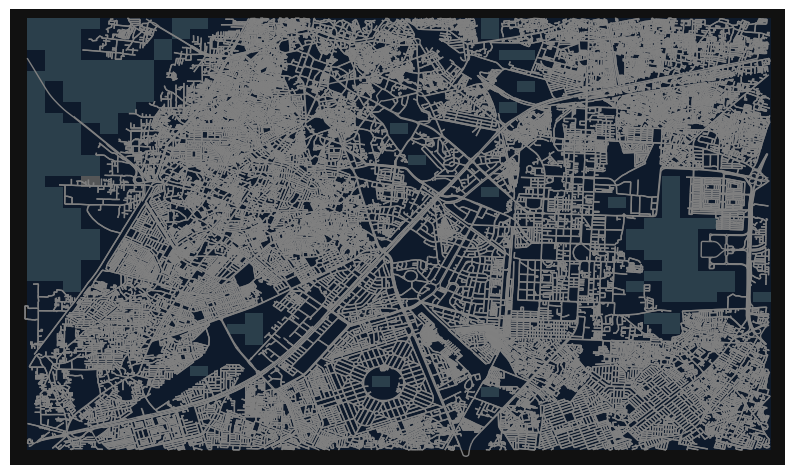

In [4]:
# Plot the road network graph
fig, ax = ox.plot_graph(G, figsize=(10, 10), node_size=0, edge_color='gray', show=False)
ax.imshow(grid, cmap='Blues', alpha=0.3, extent=(west, east, south, north))
plt.show()

A* Implementation

In [5]:
def Astar():
    graph = nx.grid_2d_graph(GRIDSIZE[0], GRIDSIZE[1])
    for obstacle in obstacles:
        graph.remove_node(obstacle)
    shortest_path = nx.astar_path(graph, start, destination)
    return shortest_path

Genetic Algorithm functions

In [6]:
# Function to calculate distance between two points
def distance(point1, point2):
    return abs(point1[0] - point2[0]) + abs(point1[1] - point2[1])

# Function to create initial population
def create_population(size, GRIDSIZE):
    population = []
    for _ in range(size):
        route = [start]
        current = start
        while current != destination:
            possible_moves = [(current[0] + 1, current[1]), (current[0] - 1, current[1]),
                              (current[0], current[1] + 1), (current[0], current[1] - 1)]
            possible_moves = [move for move in possible_moves if move[0] >= 0 and move[0] < GRIDSIZE[0] and
                              move[1] >= 0 and move[1] < GRIDSIZE[1] and move not in obstacles]
            if not possible_moves:
                current = (random.randint(0, GRIDSIZE[0] - 1), random.randint(0, GRIDSIZE[1] - 1))
            else:
                current = random.choice(possible_moves)
            route.append(current)
        population.append(route)
    return population

# Function for tournament selection
def tournament_selection(population, k=3):
    selected = []
    for _ in range(len(population)):
        participants = random.sample(population, k)
        winner = max(participants, key=evaluate_fitness)
        selected.append(winner)
    return selected

# Function for one-point crossover
def crossover(parent1, parent2):
    crossover_point = random.randint(1, min(len(parent1), len(parent2)) - 1)
    child1 = parent1[:crossover_point] + parent2[crossover_point:]
    child2 = parent2[:crossover_point] + parent1[crossover_point:]
    return child1, child2

# Function for mutation
def mutate(route, GRIDSIZE):
    mutated_route = route[:]
    for i in range(len(mutated_route)):
        if random.random() < MUTATION_RATE:
            possible_moves = [(mutated_route[i][0] + 1, mutated_route[i][1]), (mutated_route[i][0] - 1, mutated_route[i][1]),
                              (mutated_route[i][0], mutated_route[i][1] + 1), (mutated_route[i][0], mutated_route[i][1] - 1)]
            possible_moves = [move for move in possible_moves if move[0] >= 0 and move[0] < GRIDSIZE[0] and
                              move[1] >= 0 and move[1] < GRIDSIZE[1] and move not in obstacles]
            mutated_route[i] = random.choice(possible_moves)
    return mutated_route

# Function to evaluate fitness of each route
def evaluate_fitness(route):
    return -distance(route[-1], destination)  

Genetic Algorithm Implementation

In [10]:
def GA(PopSIZE,GENERATIONS):
    population = create_population(PopSIZE, GRIDSIZE)
    for generation in range(GENERATIONS):
        population = tournament_selection(population)
        next_generation = []
        while len(next_generation) < PopSIZE:
            parent1, parent2 = random.sample(population, 2)
            child1, child2 = crossover(parent1, parent2)
            child1 = mutate(child1, GRIDSIZE)
            child2 = mutate(child2, GRIDSIZE)
            next_generation.extend([child1, child2])
        population = next_generation
    return max(population, key=evaluate_fitness)

In [11]:
def main():
    PopSIZE=100
    GENERATIONS=100
    MUTATIONRATE=0.01
    OptimizedGA = GA(PopSIZE,GENERATIONS)
    OptimizedAstar = Astar()

    print("Optimized Route using Genetic Algorithm:", OptimizedGA)
    print("Optimized Route using A* Search Algorithm:", OptimizedAstar)

    # Visualization for comparison
    grid = np.zeros((GRIDSIZE, GRIDSIZE))
    for obstacle in obstacles:
        grid[obstacle] = 1
    grid[start] = 2
    grid[destination] = 3

    plt.imshow(grid, cmap='viridis', origin='lower')
    plt.plot([point[1] for point in OptimizedGA], [point[0] for point in OptimizedGA], 'r-')
    plt.plot([point[1] for point in OptimizedAstar], [point[0] for point in OptimizedAstar], 'b-')
    plt.title('Optimized Route')
    plt.show()


In [13]:
if __name__ == "__main__":
    main()

KeyboardInterrupt: 

Code is crashing IDK why?????

In [ ]:
import random
import numpy as np
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
from shapely.geometry import LineString

north, south, east, west = 31.5825, 31.4667, 74.4298, 74.2306
start = (31.5825, 74.4298)  # Ambulance station
destination = (31.4667, 74.2306)  # Accident site
obstacles = [(31.54, 74.25), (31.52, 74.27), (31.48, 74.29)]
GRID_SIZE = (40, 40)
POPULATION_SIZE = 100
MUTATION_RATE = 0.01
GENERATIONS = 100

# Function to create grid from OSMnx graph
def to_grid(G, GRIDSIZE, obstacles):
    north, east = np.max(G.nodes('y')), np.max(G.nodes('x'))
    south, west = np.min(G.nodes('y')), np.min(G.nodes('x'))
    grid = np.zeros(GRIDSIZE)
    for u, v, data in G.edges(keys=False, data=True):
        if 'geometry' in data:
            line = LineString(data['geometry'])
            coords = np.array(line.coords)
            for point in coords:
                x = int((north - point[1]) * GRIDSIZE[0] / (north - south))
                y = int((point[0] - west) * GRIDSIZE[1] / (east - west))
                if 0 <= x < GRIDSIZE[0] and 0 <= y < GRIDSIZE[1]:
                    grid[x, y] = 1
        else:
            x1, y1 = int((north - G.nodes[u]['y']) * GRIDSIZE[0] / (north - south)), \
                     int((G.nodes[u]['x'] - west) * GRIDSIZE[1] / (east - west))
            x2, y2 = int((north - G.nodes[v]['y']) * GRIDSIZE[0] / (north - south)), \
                     int((G.nodes[v]['x'] - west) * GRIDSIZE[1] / (east - west))
            dx = abs(x2 - x1)
            dy = abs(y2 - y1)
            x, y = x1, y1
            sx = 1 if x1 < x2 else -1
            sy = 1 if y1 < y2 else -1
            if dx > dy:
                err = dx / 2.0
                while x != x2:
                    if 0 <= x < GRIDSIZE[0] and 0 <= y < GRIDSIZE[1]:
                        grid[x, y] = 1
                    err -= dy
                    if err < 0:
                        y += sy
                        err += dx
                    x += sx
            else:
                err = dy / 2.0
                while y != y2:
                    if 0 <= x < GRIDSIZE[0] and 0 <= y < GRIDSIZE[1]:
                        grid[x, y] = 1
                    err -= dx
                    if err < 0:
                        x += sx
                        err += dy
                    y += sy
            if 0 <= x < GRIDSIZE[0] and 0 <= y < GRIDSIZE[1]:
                grid[x, y] = 1
    
    for obstacle in obstacles:
        x = int((north - obstacle[0]) * GRIDSIZE[0] / (north - south))
        y = int((obstacle[1] - west) * GRIDSIZE[1] / (east - west))
        if 0 <= x < GRIDSIZE[0] and 0 <= y < GRIDSIZE[1]:
            grid[x, y] = -1
    return grid

# Function to calculate distance between two points
def distance(point1, point2):
    return abs(point1[0] - point2[0]) + abs(point1[1] - point2[1])

# Function to create initial population
def create_population(size, GRID_SIZE):
    population = []
    for _ in range(size):
        route = [start]
        current = start
        while current != destination:
            possible_moves = [(current[0] + 1, current[1]), (current[0] - 1, current[1]),
                              (current[0], current[1] + 1), (current[0], current[1] - 1)]
            possible_moves = [move for move in possible_moves if move[0] >= 0 and move[0] < GRID_SIZE[0] and
                              move[1] >= 0 and move[1] < GRID_SIZE[1] and move not in obstacles]
            if not possible_moves:
                # Handle the case when there are no possible moves
                # For example, choose a random move within the grid boundaries
                current = (random.randint(0, GRID_SIZE[0] - 1), random.randint(0, GRID_SIZE[1] - 1))
            else:
                current = random.choice(possible_moves)
            route.append(current)
        population.append(route)
    return population

# Function to evaluate fitness of each route
def evaluate_fitness(route):
    return -distance(route[-1], destination)  # Fitness based

# Function for tournament selection
def tournament_selection(population, k=3):
    selected = []
    for _ in range(len(population)):
        participants = random.sample(population, k)
        winner = max(participants, key=evaluate_fitness)
        selected.append(winner)
    return selected

# Function for one-point crossover
def crossover(parent1, parent2):
    crossover_point = random.randint(1, min(len(parent1), len(parent2)) - 1)
    child1 = parent1[:crossover_point] + parent2[crossover_point:]
    child2 = parent2[:crossover_point] + parent1[crossover_point:]
    return child1, child2

# Function for mutation
def mutate(route, GRID_SIZE):
    mutated_route = route[:]
    for i in range(len(mutated_route)):
        if random.random() < MUTATION_RATE:
            possible_moves = [(mutated_route[i][0] + 1, mutated_route[i][1]), (mutated_route[i][0] - 1, mutated_route[i][1]),
                              (mutated_route[i][0], mutated_route[i][1] + 1), (mutated_route[i][0], mutated_route[i][1] - 1)]
            possible_moves = [move for move in possible_moves if move[0] >= 0 and move[0] < GRID_SIZE[0] and
                              move[1] >= 0 and move[1] < GRID_SIZE[1] and move not in obstacles]
            mutated_route[i] = random.choice(possible_moves)
    return mutated_route

# Genetic Algorithm
def genetic_algorithm():
    population = create_population(POPULATION_SIZE, GRID_SIZE)
    for generation in range(GENERATIONS):
        population = tournament_selection(population)
        next_generation = []
        while len(next_generation) < POPULATION_SIZE:
            parent1, parent2 = random.sample(population, 2)
            child1, child2 = crossover(parent1, parent2)
            child1 = mutate(child1, GRID_SIZE)
            child2 = mutate(child2, GRID_SIZE)
            next_generation.extend([child1, child2])
        population = next_generation
    return max(population, key=evaluate_fitness)

def main():
    G = ox.graph_from_bbox(north, south, east, west, network_type='drive')
    grid = to_grid(G, GRID_SIZE, obstacles)
    # Genetic Algorithm
    optimized_route_ga = genetic_algorithm()

    # A* Search Algorithm
    graph = nx.convert_node_labels_to_integers(G, label_attribute='osmid')
    shortest_path = nx.astar_path(graph, start, destination)

    print("Optimized Route (Genetic Algorithm):", optimized_route_ga)
    print("Optimized Route (A* Search Algorithm):", shortest_path)

    # Visualization (optional)
    fig, ax = ox.plot_graph_route(G, optimized_route_ga, route_linewidth=6, route_color='r', origin_point=start, destination_point=destination, show=False)
    fig, ax = ox.plot_graph_route(G, shortest_path, route_linewidth=3, route_color='b', origin_point=start, destination_point=destination, ax=ax, show=False)
    plt.show()

if __name__ == "__main__":
    main()